# ISSP 2160 Assignment 3 Problem 2 - Traveling Salesman Problem

In [150]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../param_search')
import pandas as pd
import param_search

os.chdir('/net/pulsar/home/koes/mtr22/ISSP2160/assignment-3/TSP')
import TSP, SA
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/net/pulsar/home/koes/mtr22/ISSP2160/assignment-3/TSP'

In [151]:
# create a template job script
template_file = 'sim_anneal.sh'
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
{job_params}
python3 ../mySA.py \\
    --n_trials 100 \\
    --n_steps {n_k_steps}000 \\
    --init_temp {init_temp} \\
    --cooling_fn {cooling_fn} \\
    --cooling_base {cooling_base} \\
    --no_agg \\
    > mySA.metrics

'''
with open(template_file, 'w') as f:
    f.write(template)
print(template, end='')

#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
{job_params}
python3 ../mySA.py \
    --n_trials 100 \
    --n_steps {n_k_steps}000 \
    --init_temp {init_temp} \
    --cooling_fn {cooling_fn} \
    --cooling_base {cooling_base} \
    --no_agg \
    > mySA.metrics



# Part b. Experiment with simulated annealing program

In [152]:
# define the parameter space for part b
param_space = param_search.ParamSpace(
    group_name='b',
    n_k_steps=[20, 50, 100, 200, 500, 1000],
    init_temp=[10, 20, 50, 100, 200, 500],
    cooling_fn='linear',
    cooling_base='nan',
)
len(param_space)

36

In [153]:
# setup parameterized job scripts
job_files = param_search.setup(
    expt_dir=os.getcwd(),
    name_format='sa{group_name}_{n_k_steps}_{init_temp}_{cooling_fn}_{cooling_base}',
    template_file=template_file,
    param_space=param_space
)

In [5]:
# track multiple submissions
all_job_ids = []
all_job_files = []
submit_ids = []

In [6]:
# submit jobs to the cluster
job_ids = param_search.submit(job_files)
all_job_ids.append(job_ids)
all_job_files.append(job_files)
submit_ids.append(len(submit_ids))

In [86]:
jobs = pd.DataFrame({
    'job_file': all_job_files,
    'job_id': all_job_ids,
    'submit_id': submit_ids
}).apply(pd.Series.explode).set_index('job_id')

In [87]:
# monitor job status
qstat = param_search.status(job=','.join(map(str, job_ids))).set_index('job_id')
qstat

def update_jobs(jobs, qstat):
    both_cols = [c for c in qstat if c in jobs]
    jobs = jobs.merge(qstat, on='job_id', how='left', suffixes=('_old', '_new'))
    
    for col in both_cols: # resolve merge conflicts
        new_col, old_col = col+'_new', col+'_old'
        
        if col == 'job_state': # always update
            jobs[col] = jobs[new_col]
            
        else: # update when new value is not null
            jobs[col] = jobs[new_col].where(jobs[new_col].notnull(), jobs[old_col])
    
    jobs = jobs.drop([c+'_new' for c in both_cols], axis=1)
    jobs = jobs.drop([c+'_old' for c in both_cols], axis=1)
    return jobs

jobs = update_jobs(jobs, qstat)
jobs.reset_index().groupby('job_state')[['job_id']].count()

,job_id
job_state,


In [88]:
# check jobs for errors
jobs['stdout'] = param_search.job_output.get_job_outputs(sum(all_job_files, []))
jobs['stderr'] = param_search.job_output.get_job_errors(sum(all_job_files, []))
jobs.reset_index().groupby('stderr')[['job_id']].count()

....................................................................................................................................................................................................................

,job_id
stderr,


In [154]:
# read output metrics
metrics = param_search.metrics(job_files)

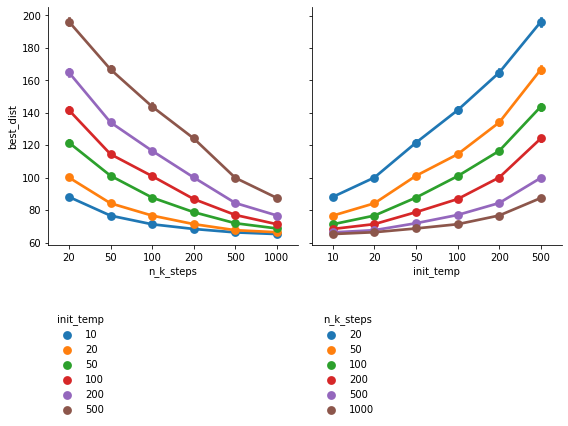

In [156]:
import param_search

# plot metrics wrt parameters
fig = param_search.plot(
    metrics[metrics['group_name'] == 'b'],
    y='best_dist',
    x=['n_k_steps', 'init_temp'],
    hue=True,
    n_cols=3,
    width=4,
    height=6.4,
    tight=True
)

In [160]:
metrics.groupby('job_name')['best_dist'].mean().sort_values()

job_name
sab_1000_10_linear_nan      65.2926
sab_500_10_linear_nan       66.3133
sab_1000_20_linear_nan      66.4170
sab_500_20_linear_nan       67.6734
sab_200_10_linear_nan       68.4283
sab_1000_50_linear_nan      68.7396
sab_100_10_linear_nan       71.3188
sab_1000_100_linear_nan     71.3544
sab_200_20_linear_nan       71.4163
sab_500_50_linear_nan       71.9616
sab_50_10_linear_nan        76.6412
sab_100_20_linear_nan       76.6727
sab_1000_200_linear_nan     76.7216
sab_500_100_linear_nan      77.0534
sab_200_50_linear_nan       78.7891
sab_50_20_linear_nan        84.2526
sab_500_200_linear_nan      84.4269
sab_200_100_linear_nan      86.8685
sab_1000_500_linear_nan     87.5165
sab_100_50_linear_nan       87.7761
sab_20_10_linear_nan        88.1869
sab_500_500_linear_nan      99.9279
sab_20_20_linear_nan       100.1436
sab_200_200_linear_nan     100.1602
sab_100_100_linear_nan     100.9985
sab_50_50_linear_nan       101.2220
sab_50_100_linear_nan      114.4943
sab_100_200_linear_

In [168]:
best_a = metrics.set_index('job_name').loc['sab_100_100_linear_nan'].sort_values('best_dist').iloc[:1]
print(best_a.best_tour.item().replace(',', ', '))
best_a[['init_dist', 'best_dist', 'n_tours_tried', 'n_tours_accepted']]

0, 16, 39, 45, 46, 14, 9, 2, 55, 48, 40, 43, 56, 25, 29, 47, 7, 27, 1, 34, 18, 36, 3, 11, 28, 54, 51, 57, 23, 41, 6, 58, 44, 20, 4, 21, 10, 13, 31, 22, 19, 49, 8, 35, 59, 30, 38, 52, 12, 37, 26, 24, 42, 5, 53, 50, 15, 33, 17, 32


,init_dist,best_dist,n_tours_tried,n_tours_accepted
job_name,,,,
sab_100_100_linear_nan,283.73,88.49,100000.0,92195.0


In [169]:
best_b = metrics.groupby('job_name')['best_dist'].mean().sort_values().index[0]
best_b = metrics.set_index('job_name').loc[best_b].sort_values('best_dist').iloc[:1]
print(best_b.best_tour.item().replace(',', ', '))
best_b[['init_dist', 'best_dist', 'n_tours_tried', 'n_tours_accepted']]

0, 16, 14, 30, 42, 24, 26, 38, 37, 12, 52, 46, 9, 2, 55, 20, 4, 40, 59, 48, 6, 10, 35, 21, 22, 19, 8, 49, 31, 13, 58, 41, 54, 44, 43, 28, 11, 57, 3, 56, 25, 23, 51, 47, 29, 7, 50, 1, 27, 15, 34, 33, 18, 36, 17, 45, 39, 32, 53, 5


,init_dist,best_dist,n_tours_tried,n_tours_accepted
job_name,,,,
sab_1000_10_linear_nan,296.69,63.67,1000000.0,592074.0


## Part c. Cooling schedule competition

In [170]:
# define the parameter space for part c
param_space = param_search.ParamSpace(
    group_name='c',
    n_k_steps=20,
    init_temp=[1, 2, 5, 10, 20],
) * (
    param_search.ParamSpace(cooling_fn='linear', cooling_base='nan') + 
    param_search.ParamSpace(cooling_fn='cosine', cooling_base='nan') + 
    param_search.ParamSpace(cooling_fn='power', cooling_base=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5]) + 
    param_search.ParamSpace(cooling_fn='step', cooling_base=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5])
)

len(param_space)

70

In [171]:
# setup parameterized job scripts
job_files = param_search.setup(
    expt_dir=os.getcwd(),
    name_format='sa{group_name}_{n_k_steps}_{init_temp}_{cooling_fn}_{cooling_base}',
    template_file=template_file,
    param_space=param_space
)

In [11]:
# submit jobs to the cluster
job_ids = param_search.submit(job_files)
all_job_ids.append(job_ids)
all_job_files.append(job_files)
submit_ids.append(len(submit_ids))

In [76]:
jobs = pd.DataFrame({
    'job_file': all_job_files,
    'job_id': all_job_ids,
    'submit_id': submit_ids
}).apply(pd.Series.explode).set_index('job_id')

In [77]:
# monitor job status
qstat = param_search.status(job=','.join(map(str, job_ids))).set_index('job_id')
qstat

jobs = update_jobs(jobs, qstat)
jobs.reset_index().groupby('job_state')[['job_id']].count()

,job_id
job_state,


In [78]:
# check jobs for errors
jobs['stdout'] = param_search.job_output.get_job_outputs(sum(all_job_files, []))
jobs['stderr'] = param_search.job_output.get_job_errors(sum(all_job_files, []))
jobs.reset_index().groupby('stderr')[['job_id']].count()

....................................................................................................................................................................................................................

,job_id
stderr,


In [172]:
# read output metrics
metrics = param_search.metrics(job_files)
metrics.shape

(7000, 12)

../param_search/param_search/results.py:205: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


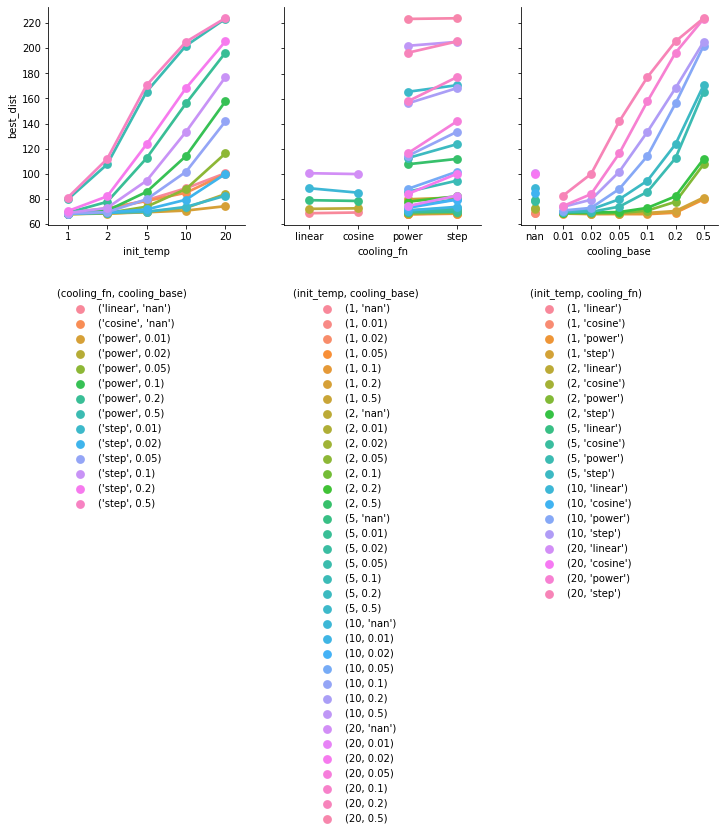

In [173]:
import param_search

# plot metrics wrt parameters
fig = param_search.plot(
    metrics[metrics['group_name'] == 'c'],
    y='best_dist',
    x=['init_temp', 'cooling_fn', 'cooling_base'],
    hue=True,
    n_cols=3,
    width=4,
    height=4,
)

In [174]:
best_c = metrics.groupby('job_name')['best_dist'].mean().sort_values().index[0]
best_c = metrics.set_index('job_name').loc[best_c].iloc[0:1]
print(best_c.best_tour.item().replace(',', ', '))
best_c[['init_dist', 'best_dist', 'n_tours_tried', 'n_tours_accepted']]

0, 42, 30, 16, 14, 24, 26, 38, 37, 12, 52, 46, 2, 9, 55, 20, 4, 40, 48, 41, 58, 13, 31, 49, 8, 19, 22, 21, 10, 6, 35, 59, 36, 18, 33, 34, 15, 29, 25, 23, 56, 3, 44, 54, 43, 28, 57, 11, 51, 47, 7, 50, 1, 27, 17, 45, 39, 32, 5, 53


,init_dist,best_dist,n_tours_tried,n_tours_accepted
job_name,,,,
sac_20_1_power_0.1,315.15,66.32,20000.0,1506.0


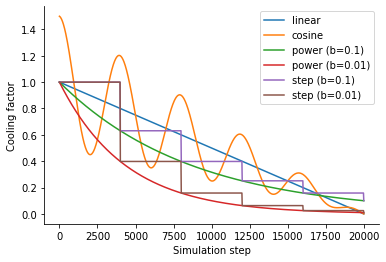

In [175]:
# plot the cooling schedules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mySA

n_steps = 20000
x = np.linspace(0, n_steps, 1000)
y0 = np.vectorize(SA.linear_cooling)(x, n_steps)
y1 = np.vectorize(mySA.cosine_cooling)(x, n_steps, f=10)
y2 = np.vectorize(mySA.power_cooling)(x, n_steps, b=0.1)
y3 = np.vectorize(mySA.power_cooling)(x, n_steps, b=0.01)
y4 = np.vectorize(mySA.step_cooling)(x, n_steps, b=0.1)
y5 = np.vectorize(mySA.step_cooling)(x, n_steps, b=0.01)

plt.plot(x, y0, label='linear')
plt.plot(x, y1, label='cosine')
plt.plot(x, y2, label='power (b=0.1)')
plt.plot(x, y3, label='power (b=0.01)')
plt.plot(x, y4, label='step (b=0.1)')
plt.plot(x, y5, label='step (b=0.01)')
plt.legend()
plt.xlabel('Simulation step')
plt.ylabel('Cooling factor')
sns.despine(plt.gcf())
plt.savefig('cooling_schedules.pdf', bbox_inches='tight')